In [181]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special
from scipy import integrate

In [182]:
time = 2.0*np.pi # total time in seconds
dt=0.1 # Timestep
nt = int(time / dt) # number of time steps
t0=0; theta0=np.pi*0.5; #Initial time and value

order = 3 # order of symplectic integrator

k = 1.0 # define k
g = 10 # define g for energy analysis

t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

In [183]:
# Euler's method (1st order symplectic)
def euler(t,k,dt,theta0):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    
    for i in range(nt-1):
        u[i+1] = u[i] - dt*np.sin(theta[i])*k**2
        #theta[i+1] = theta[i] + dt*u[i] # Euler's method
        theta[i+1] = theta[i] + dt*u[i+1] # Semi-implicit Euler's method
        
    return [theta,u]
    
thetaEuler,uEuler = euler(t,k,dt,theta0)

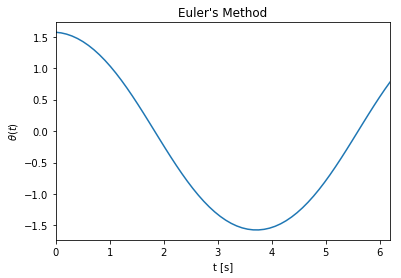

In [184]:
#Plot the result of Euler's method
plt.plot(t,thetaEuler)
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.title("Euler's Method")
plt.show()

In [185]:
# Symplectic integrator coefficients
# 1st order: ci = [1 0 0 0] di = [1 0 0 0]
# 2nd order: ci = [0 1 0 0] di = [0.5 0.5 0 0] 
# 3rd order: ci = [1 -2/3 2/3 0] di = [-1/24 3/4 7/24 0] 
# 4th order: let x = 2-2^(1/3) c1=c4=1/2x, c2=c3=[1-2^(1/3)]/2x, d1=d3=1/x d2=-2^(1/3)/x  d4=0

def symplectic(t,k,dt,theta0,order):
    
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
        
    for i in range(nt-1):
        u[i+1] = u[i] - d[0]*dt*np.sin(theta[i])*k**2
        theta[i+1] = theta[i] + c[0]*dt*u[i+1]
        
        u[i+1] = u[i+1] - d[1]*dt*np.sin(theta[i+1])*k**2
        theta[i+1] = theta[i+1] + c[1]*dt*u[i+1]
        
        u[i+1] = u[i+1] - d[2]*dt*np.sin(theta[i+1])*k**2
        theta[i+1] = theta[i+1] + c[2]*dt*u[i+1]
        
        u[i+1] = u[i+1] - d[3]*dt*np.sin(theta[i+1])*k**2
        theta[i+1] = theta[i+1] + c[3]*dt*u[i+1]
        
    return [theta,u]
    
thetaSym,uSym = symplectic(t,k,dt,theta0,order)

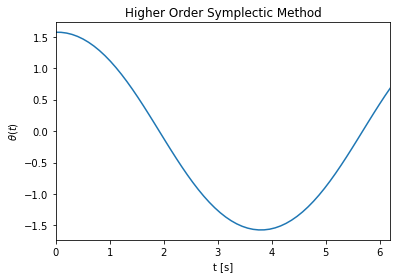

In [186]:
#Plot the result of symplectic integrator
plt.plot(t,thetaSym)
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.title("Higher Order Symplectic Method")
plt.show()

In [187]:
# Analytical solution

def analytical(t,k,theta0):

    x = np.sin(theta0/2)
    eK = sp.special.ellipk(x**2) # complete elliptic integral of the first kind
    eJ = sp.special.ellipj(eK - k*t, x**2) # Jacobian elliptic function
    thetaAna = 2*np.arcsin(x*eJ[0]) # ellipj returns 4 values, we only need 1st
    
    return thetaAna

thetaAna = analytical(t,k,theta0)
uAna = np.gradient(thetaAna,dt)

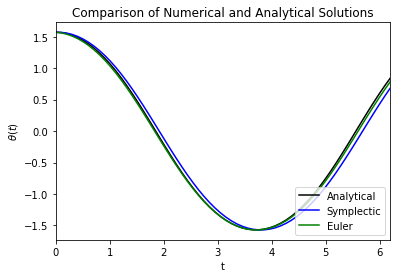

In [188]:
#Plot the result
plt.plot(t,thetaAna,color='k',label='Analytical') #Analytical solution is black
plt.plot(t,thetaSym,color='b',label='Symplectic') # Symplectic solution is blue
plt.plot(t,thetaEuler,color='g',label='Euler') # Euler solution is green
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.title("Comparison of Numerical and Analytical Solutions")
plt.legend(loc=4)
plt.show()

In [189]:
def energy(u,theta):
    
    return g**2/k**2*(1/(2*k**2)*u**2-np.cos(theta))

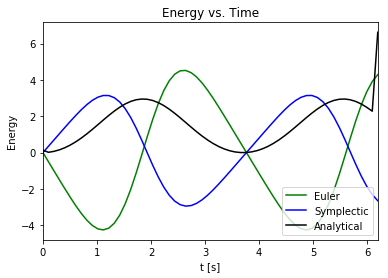

In [190]:
energyEuler = energy(uEuler,thetaEuler)
energySym = energy(uSym,thetaSym)
energyAna = energy(uAna,thetaAna)
  
plt.plot(t,energyEuler,color='g',label='Euler')
plt.plot(t,energySym,color='b',label='Symplectic')
plt.plot(t,energyAna,color='k',label='Analytical')

plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.xlim(0,dt*nt)
plt.title("Energy vs. Time")
plt.legend(loc=4)
plt.show()

-0.0576666292291
-0.158474173437


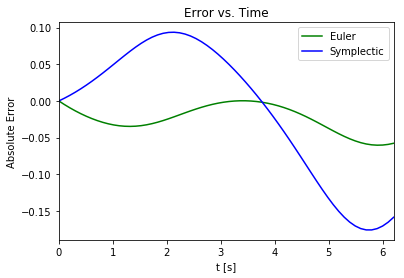

In [191]:
#Plot the error
errEuler = thetaEuler - thetaAna 
errSym = thetaSym - thetaAna

# use error at last time step
print(errEuler[-1])
print(errSym[-1])

plt.plot(t,errEuler,color='g',label="Euler") # Euler function error is green
plt.plot(t,errSym,color='b',label="Symplectic") # Symplectic error is blue
plt.xlabel('t [s]')
plt.ylabel('Absolute Error')
plt.xlim(0,dt*nt)
plt.title("Error vs. Time")
plt.legend()
plt.show()

In [192]:
j = np.arange(0,10,1.0)
h = 0.1*2**(-j) # list of dt values

err1=np.zeros(h.size); err2=np.zeros(h.size); err3=np.zeros(h.size); err4=np.zeros(h.size);

for i in range(h.size):
    print(i,end=" ") # display progress
    nt = int(time/h[i])
    tvec = np.linspace(t0,time,nt)
    
    thetaA = analytical(tvec,k,theta0)
    theta1 = euler(tvec,k,h[i],theta0)[0] # solutions for order 1-4
    theta2 = symplectic(tvec,k,h[i],theta0,2)[0]
    theta3 = symplectic(tvec,k,h[i],theta0,3)[0]
    theta4 = symplectic(tvec,k,h[i],theta0,4)[0]
    
    # total error over time for each 
    error1 = theta1 - thetaA
    error2 = theta2 - thetaA
    error3 = theta3 - thetaA
    error4 = theta4 - thetaA
    
    # Error at final time step
    #err1[i] = np.abs(error1[-1])
    #err2[i] = np.abs(error2[-1])
    #err3[i] = np.abs(error3[-1])
    #err4[i] = np.abs(error4[-1])
    
    # Integrate squared error over time
    err1[i] = np.sqrt(sp.integrate.simps(error1**2,tvec))
    err2[i] = np.sqrt(sp.integrate.simps(error2**2,tvec))
    err3[i] = np.sqrt(sp.integrate.simps(error3**2,tvec))
    err4[i] = np.sqrt(sp.integrate.simps(error4**2,tvec))
    
    

0 1 2 3 4 5 6 7 8 9 

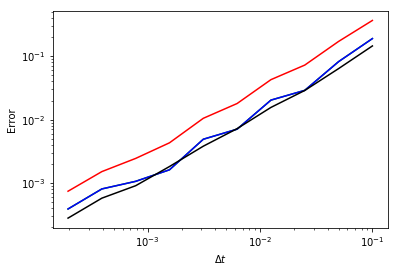

0.982623428742
0.982623428733
0.989139289527
0.99184364388


In [193]:
# loglog plot, Error vs 1/dt
plt.loglog(h,err1,color='g')
plt.loglog(h,err2,color='b')
plt.loglog(h,err3,color='r')
plt.loglog(h,err4,color='k')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Error')
plt.show()

# find slope of loglog plot
slope1 = np.polyfit(np.log(h),np.log(err1),1)[0]
slope2 = np.polyfit(np.log(h),np.log(err2),1)[0]
slope3 = np.polyfit(np.log(h),np.log(err3),1)[0]
slope4 = np.polyfit(np.log(h),np.log(err4),1)[0]

print(slope1)
print(slope2)
print(slope3)
print(slope4)